### Solar Panel Placement Optimization Notebook 

We recommend to write your code in Python, so that your workflow can be seen using this notebook. However, feel free to use other languages and tools that you are comfortable with. 

Please generate images to illustrate how your algorithm works. 

Have fun! 

Run this cell first to define variables and import neccessary libraries

In [379]:
from shapely import Polygon, buffer, get_coordinates, bounds, covers, prepare, affinity, centroid
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon
import math

#* All numbers are in meters
testCoordinate1 = [(0, 0), (0, 100), (50, 0)]
testCoordinate2 = [(1.12, 130.83), (1.12, 160.83), (31.12, 160.83), (31.12, 130.83), (11.12, 100.83), (-11.12, 90.83), (-30.12, 90.83), (-20.182, 120.273)]
testCoordinate3 = [(2, 100), (2,160), (131, 160), (35, 200), (11, 300), (-20 , 90), (30, 90)]
testCoordinate4 = [(0, 0), (100,0), (0,50)] #* for testing purposes

panelSizes = [(2,1),(2.3,1),(1.8,0.9),(1,2),(1,2.3),(0.9,1.8)] #* (length, width)
panelGap = 0.02
rowSpacing = 0.5

COORDS = testCoordinate4
PRECISION = -1  #* use -1 for auto adjustment

# Helper Functions -

In [380]:
# Helper functions:

#* I'll start by getting the areas of the different rooftops - this will give us a benchmark of our layout's coverage. 
#* Formula for calculating area of shape using coordinates of vertices:
#* |((x1y2 - y1x2) + (x2y3 - y2x3) ... + (xny1 - ynx1)) / 2 |
def getRoofArea(polygon):
  # numerator = 0
  # for i in range(len(coords)):
  #   nextIndex = (i + 1) % len(coords)
  #   numerator += (coords[i][0] * coords[nextIndex][1]) - (coords[i][1] * coords[nextIndex][0])
  # area = abs(numerator / 2)
  # return area
  
  #* Scratch that, I found a library (shapely) that deals with geometric objects
  return polygon.area

#* returns an array [half of width, half of length] of given panel size.
def getOffsetDistance(panelSize):
  return [panelSize[0]/2, panelSize[1]/2]

#* returns the area of 1 panel
def getPanelArea(panelSize):
  return panelSize[0] * panelSize[1]

#* returns the total coverage area of all the panels
def getCoverageArea(grid, panelSize):
  return len(grid) * getPanelArea(panelSize)

#* returns a precision value based on the area of the roof
def getPrecision(polygon):
  if PRECISION != -1:
    return PRECISION
  
  area = getRoofArea(polygon)
  if area <= 2500:
    return 5
  elif area <= 5000:
    return 4
  elif area <= 10000:
    return 3
  elif area <= 20000:
    return 2
  else: return 1
  
#* returns an array of panel sizes based on the area of the roof
def getPanels(polygon):
  area = getRoofArea(polygon)
  if area <= 2500:
    return panelSizes[3:]
  elif area <= 5000:
    return panelSizes[3:5]
  else: return [panelSizes[4]]
  
#* takes in an angle of rotation, array of coordinates, and the pivot point, and returns the rotated array of coordinates
def rotateGrid(angle, unrotatedGrid, pivotPoint):
  rotatedGrid = []
  angleInRad = math.radians(angle)
  for panel in unrotatedGrid:
    rotatedPanel = []
    for corner in panel:
      x = corner[0]-pivotPoint[0]
      y = corner[1]-pivotPoint[1]
      rotatedX = (x * math.cos(angleInRad)) - (y * math.sin(angleInRad)) + pivotPoint[0]
      rotatedY = (x * math.sin(angleInRad)) + (y * math.cos(angleInRad)) + pivotPoint[1]
      rotatedPanel.append([rotatedX, rotatedY])
    rotatedGrid.append(rotatedPanel)
  return rotatedGrid

Starting Point - a point within the roof geometry that a solar panel is guaranteed to fit inside. 

The function will offset the polygon inwards by half of the longest side of the chosen solar panel, and return the point on this offset curve with the smallest value of X and Y (bottom left)

In [381]:
#* not used

def getStartingPoint(polygon, panelSize):
  offsetDistance = max(getOffsetDistance(panelSize)) * -1
  offsetPolygon = buffer(polygon, offsetDistance, cap_style="square", join_style="mitre")
  minX, minY, maxX, maxY = bounds(offsetPolygon)
  offsetCoordinates = get_coordinates(offsetPolygon).tolist()
  startingPoint = []
  
  for offsetCoord in offsetCoordinates:
    if offsetCoord[1] == minY:
      if not startingPoint:
        startingPoint = offsetCoord
      elif offsetCoord[0] < startingPoint[0]:
          startingPoint = offsetCoord
  
  return offsetCoordinates,startingPoint


# offset, startingPoint = getStartingPoint(testCoordinate3, panelSizes[0])
# print(startingPoint)

Alternatively, I could directly offset the minX, minY point and start my grid from there - this will be the method I implemented. 

Using the starting point and the offset bounding box as the bounds, I generate a grid of points which will be the <u>center points</u> of each individual solar panel.

This grid is merely an entire grid of points within the bounding box. I will use an additional function below to filter out the valid points where solar panels can be placed.

In [382]:
def getGrid(polygon, panelSize, shiftX = 0, shiftY = 0):
  offsetX, offsetY = getOffsetDistance(panelSize)
  
  minX, minY, maxX, maxY = bounds(polygon)

  def meterToMM(num):
    return int(1000 * num)
  
  def mmToMeter(num):
    return num/1000

  #* redefine all variables in mm as to avoid errors in using float values
  startXmm = meterToMM(minX + offsetX)
  startYmm = meterToMM(minY + offsetY)
  maxXmm = meterToMM(maxX - offsetX)
  maxYmm = meterToMM(maxY - offsetY)
  shiftXmm = meterToMM(shiftX)
  shiftYmm = meterToMM(shiftY)
  rowSpacingmm = meterToMM(rowSpacing)
  panelGapmm = meterToMM(panelGap)
  panelXmm = meterToMM(panelSize[0])
  panelYmm = meterToMM(panelSize[1])
  
  grid = []
  
  for y in range(startYmm - shiftYmm, maxYmm, panelYmm + rowSpacingmm):
    for x in range(startXmm - shiftXmm, maxXmm, panelXmm + panelGapmm):
      #* conversion back to Meters
      grid.append([mmToMeter(x) ,mmToMeter(y)])
    
  return grid

This function will take each point in the grid and extrapolate the 4 corner points of the solar panel, then check if all corners are "contained" within the roof polygon. If yes, then this is a valid solar panel placement.

In [383]:
def panelsOnRoof(polygon, grid, panelSize):
  validGrid = []
  offsetX, offsetY = getOffsetDistance(panelSize)
  for point in grid:
    x,y = point
    minusX = x - offsetX
    addX = x + offsetX
    minusY = y - offsetY
    addY = y + offsetY
    
    topLeft = (minusX, addY)
    topRight = (addX, addY)
    bottomLeft = (minusX, minusY)
    bottomRight = (addX, minusY)
    
    panelCoords = [topLeft, topRight,bottomRight,bottomLeft]
    panelPolygon = Polygon(panelCoords)
    
    if covers(polygon,panelPolygon):
      validGrid.append(panelCoords)
    
  return validGrid 

Create a function to visualise the rooftop shapes using matplotlib

In [384]:
def visualiseRooftop(roofCoords, panelGrid):
  x = []
  y = []
  fig, ax = plt.subplots()

  for coord in roofCoords:
    # plt.plot(coord[0], coord[1], marker = "o")
    x.append(coord[0])
    y.append(coord[1])
    
  x.append(roofCoords[0][0])
  y.append(roofCoords[0][1])

  ax.plot(x,y, color="black")
  ax.fill(x,y, color="lightgrey")

  for panelCorners in panelGrid:
    panelPolygon = mplPolygon(panelCorners, closed=True, facecolor="mediumblue")
    ax.add_patch(panelPolygon)
    # plt.plot(panel[0],panel[1], marker = "s")
    
  ax.autoscale()
  ax.set_aspect("equal", "box")
  plt.show()
  
  return

## Algorithm discussion
During my [M.Arch thesis](https://www.ar-dan.com/what-the-farm), I used Rhino and Grasshopper to run simulations on building rooftops and facades - the general idea was to see if any slight rotations in buildings could lead to significantly more sunlight for vertical farming. The program used an evolutionary algorithm to return the ideal configuration.

Doing something similar was my first thought when I saw the assignment, but thinking deeper about it, I don't think its the correct path to go down. The key differences was that the daylight simulations I had previously used were very computationally intensive, taking 3-5min per simulation, and I had about 5 buildings to rotate. Using an evolutionary algorithm meant that I didn't need to test all possible permutations, but could narrow down quickly and reduce computation time. Perhaps this is something that could be explored further in the future.

Additionally, since one of the assignment's objective is to assess the quality of my thought process, I will work to develop my algorithm rather than just plugging the data into an already developed algorithm.

My first instinct was that I should start without rotation, and just differing panel sizes. However, after more time spent thinking about the problem, my hypothesis (and what I will build my algorithm off) is that:
- The **rotation will actually have the largest impact on coverage** (may not apply to all cases, will discuss my assumptions later). 
- Choose the best rotation (perhaps include more rotation values if the preliminary results are close)
- Test all combinations of panel sizes and shifting (x & y)

### Rotation
There are 2 main optimisations that I think will significantly reduce the computational requirements.
- Instead of rotating the solar panels itself (which will make keeping the aligned rows and columns difficult), we can simply <u>rotate the roof</u> to achieve the same result. Thus, the solar panels will always be aligned orthogonally. 
- Instead of testing rotation based on a fixed "step" (e.g testing in increments of 5 degrees), my instinct tells me that the best orientations would be when at least <u>1 edge is at 0 degrees</u>. 

Using trigonometry, I can calculate the angle of the edge with the coordinates of adjacent vertices. It is important to include the normal (90 degree) rotation as well, to account for the 2 possible orientations of the solar panel itself.



In [385]:
def getEdgeAngles(roofCoords):
  angles = set()
  
  #* needs more testing with more complex roofs to dial in the simplifying amount
  if len(roofCoords) > 10:
    simplifiedPoly = Polygon(roofCoords).simplify(10, preserve_topology=False)
    roofCoords = get_coordinates(simplifiedPoly).tolist()
    
  for i in range(len(roofCoords)):
    currPoint = roofCoords[i]
    nextPoint = roofCoords[(i + 1) % len(roofCoords)]
    
    #* calculate the angle using arc tangent (opposite/adjacent)
    height = nextPoint[1] - currPoint[1]
    length = nextPoint[0] - currPoint[0]
    angle = math.degrees(math.atan2(height,length))
    
    #* check if opposite of angle is already in the set (no point checking both 30 degrees and 210 degrees (180 + 30))
    if angle >= 180:
      if angle - 180 not in angles:
        angles.add(angle)
        angles.add((angle + 90) % 180)
    elif angle > 0:
      if angle + 180 not in angles:
        angles.add(angle)
        angles.add((angle + 90) % 180)
    else:
      angles.add(angle)
      angles.add((angle + 90) % 180)
      
  return list(angles)

### Panel sizes and XY-shifting
After rotation, we test the different configuration of panel sizes along with shifting the panels along the X & Y axes. 
- Initally, I set the precision as a global variable, which can be manually adjusted.
- However, part of the assignment was for this algorithm to be lightweight enough to run on the backend.

### Optimisation
- Decided to write a short script to adjust the precision automatically 
    - Some quick experimentation determined that the biggest factor for computational demand was the size of the roof (each panel's 4 corners need to be checked if its inside the roof. More area = more panels = more calculation). 
    - If precision is low, then the shift amount should be kept to a minimum backwards
- Simplifying the roof geometry based on the number of number of vertices (directly proportional to number of sides) - although none of the 3 test cases had any significant impact on computational requirements, if a user submits a rounded roof, the number of calculations would be extremely high.
- Panel choices
    - Based on my findings, the smallest panel consistently performed the worst - simply because more panels are required and hence more space is wasted in panel gaps and row spacings.
    - Additionally, orienting the panels in portrait consistently results in better coverage. This is because there are lesser rows, and the row spacing is significantly larger than the panel gap
    - Hence, reducing the panels choices to 2 x 1 and 2.3 x 1 in portrait will reduce the calculations required, whilst typically still being able to achieve the same result
    - Lastly, added a short script to reduce the number of panels to just (2.3 x 1) if the roof area is large to further reduce the load.

[33.33333333333333, 16.666666666666664]
Best Angle: 90.0 
Best XY Shift: (0.0, 0.0) 
Best Panel: (1, 2.3) 
Max Coverage: 1936.6
Roof Area: 2500.0 
Percentage Coverage: 77.464 %


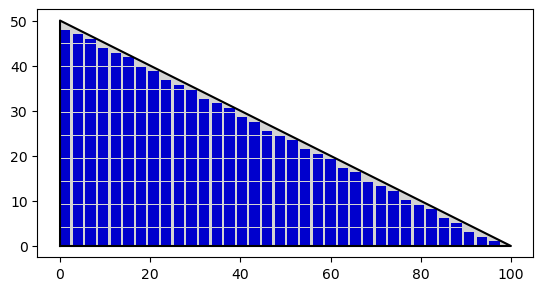

In [388]:
def main():
  roofPolygon = Polygon(COORDS)
  #* get roof angles
  angles = getEdgeAngles(COORDS)
  pivotPoint = get_coordinates(centroid(roofPolygon)).tolist()[0]
  panels = getPanels(roofPolygon)
  
  bestXY = (0,0)
  bestPanel = panels[0]
  maxCoverage = 0
  
  precision = getPrecision(roofPolygon)
  # precision = 5
  
  #* a quick test for my hypothesis - to check if "odd" angles can achieve better results. Fortunately my hypothesis seems to be correct.
  #* this can significantly reduce the computational requirements
  # angles = []
  # for num in range(0, 360, 5):
  #   angles.append(num)
  
  #* testing different angles where at least 1 edge is parallel to the x-axis (and its corresponding 90degree rotation)
  for angle in angles:
    rotatedRoof = affinity.rotate(roofPolygon, angle, origin="centroid")
    
    #* preparing will reduce computational load for complex roof shapes
    prepare(rotatedRoof)
  
    gridOfCenters = getGrid(rotatedRoof, bestPanel)
    gridOfValidPanels = panelsOnRoof(rotatedRoof,gridOfCenters, bestPanel)
    coverageArea = getCoverageArea(gridOfValidPanels, bestPanel)
    if coverageArea > maxCoverage:
      maxCoverage = coverageArea
      bestRoof = rotatedRoof
      bestAngle = angle
    # print("angle:", angle, "\n coverage area:", coverageArea)
  
  # print(bestAngle, maxCoverage)
  
  
  #* testing both panel size and xy shifting of different panels
  for panel in panels:
  # for panelSize in panelSizes[0:1]:
    for shiftXfrac in range(0,precision):
      for shiftYfrac in range(0,precision):
        shiftX = panel[0] * (shiftXfrac / precision)
        shiftY = panel[1] * (shiftYfrac / precision)
        gridOfCenters = getGrid(bestRoof, panel, shiftX, shiftY)
        gridOfValidPanels = panelsOnRoof(bestRoof, gridOfCenters, panel)
        coverageArea = getCoverageArea(gridOfValidPanels, panel)
        # print(coverageArea, panel, shiftX, shiftY)
        if coverageArea > maxCoverage:
          maxCoverage = coverageArea
          bestXY = shiftX, shiftY
          bestPanel = panel
          bestGrid = gridOfValidPanels
          
  print("Best Angle:", bestAngle, "\nBest XY Shift:", bestXY, "\nBest Panel:", bestPanel,"\nMax Coverage:", maxCoverage)
  
  roofArea = getRoofArea(roofPolygon)
  print("Roof Area:", roofArea,"\nPercentage Coverage:", maxCoverage * 100 / roofArea, "%")
  
  bestUnrotatedGrid = rotateGrid((bestAngle * -1), bestGrid, pivotPoint)
  
  visualiseRooftop(COORDS, bestUnrotatedGrid)
  
main()

### Limitations:
With every optimisation, there will come a tradeoff
- Rotation
  - As we do not test rotation for each panel size and shift, there may be situations where a different rotation value may lead to a better result
  - For complex shapes (curves or roofs with many edges), the rotation angles are based off a simplified geometry. The algorithm may not be able to find the best roof angle
- Size
  - As the roofs get bigger, we exclude the smaller panels. There may be some specific roof shapes where smaller panels will have better coverage.
- Shift
  - Similar to the above, we check less X and Y shifts as the roofs increase in size. We may miss out opportunities in some cases.

### Additional Info
- Experimentation with precision values and timings
  
| Coords                      | Area  | Precision | Time | Result  |
|-----------------------------|-------|-----------|------|---------|
| (0, 0), (0, 70), (35, 0)    | 1225  | 1         | 0.3  | 772.8   |
|                             |       | 2         | 0.7  | 772.8   |
|                             |       | 3         | 1.2  | 772.8   |
|                             |       | 4         | 2.1  | 772.8   |
|                             |       | 5         | 3.1  | 772.8   |
| (0, 0), (0, 100), (50, 0)   | 2500  | 1         | 0.6  | 1578    |
|                             |       | 2         | 1.3  | 1578    |
|                             |       | 3         | 2.5  | 1578    |
|                             |       | 4         | 4    | 1578    |
|                             |       | 5         | 6.3  | 1578    |
| [(0, 0), (0, 150), (75, 0)] | 5625  | 1         | 1.4  | 3618    |
|                             |       | 2         | 3    | 3620.2  |
|                             |       | 3         | 5.5  | 3618    |
|                             |       | 4         | 9.2  | 3634    |
|                             |       | 5         | 13.5 | 3632    |
| [(0, 0), (0, 170), (85, 0)] | 7225  | 1         | 2    | 4672    |
|                             |       | 2         | 3.8  | 4672    |
|                             |       | 3         | 7.2  | 4672    |
|                             |       | 4         | 11.8 | 4680.5  |
|                             |       | 5         | 18.2 | 4675.9  |
| (0, 0), (0, 200), (100, 0)  | 10000 | 1         | 2.3  | 6502    |
|                             |       | 2         | 5.4  | 6502    |
|                             |       | 3         | 9.4  | 6502    |
|                             |       | 4         | 15.8 | 6502    |
|                             |       | 5         | 23.5 | 6502.01 |
| (0, 0), (0, 300), (150, 0)  | 22500 | 1         | 5.6  | 14632   |
|                             |       | 2         | 12   | 14632   |
|                             |       | 3         | 21.1 | 14632   |
|                             |       | 4         | 34.8 | 14632   |
|                             |       | 5         | 53.3 | 14632   |
| (0, 0), (0, 380), (190, 0)  | 36000 | 0         | 5.6  | 23614   |